### Короткий опис архітектури GAN
- Перша модель називається Генератор і має на меті генерувати нові дані, подібні до очікуваних. Генератор можна прирівняти до людини-підробника мистецтва, яка створює підроблені твори мистецтва.
- Друга модель називається Дискримінатор. Мета цієї моделі — розпізнати, чи є вхідні дані «справжніми» — належать до оригінального набору даних — чи «фальшивими» — створеними фальсифікатором. У цьому сценарії Дискримінатор є аналогом експерта з мистецтва, який намагається виявити твори мистецтва як правдиві чи шахрайські.
- Перефразовуючи оригінальну статтю, яка пропонує цю структуру, можна вважати, що Generator має супротивника, Discriminator. Генератор (підробник) повинен навчитися створювати дані таким чином, щоб Дискримінатор більше не міг розпізнати їх як підроблені. Конкуренція між ними двома покращує їхні знання, доки Генератору не вдасться створити реалістичні дані.

### Математичне пояснення
- Після кількох кроків навчання, якщо Генератор і Дискримінатор мають достатню потужність (якщо мережі можуть наблизити цільові функції), вони досягнуть точки, на якій обидва більше не зможуть вдосконалюватися. На цьому етапі генератор генерує реалістичні синтетичні дані, а дискримінатор не в змозі відрізнити два типи вхідних даних.
- Оскільки під час навчання дискримінатор і генератор намагаються оптимізувати протилежні функції втрат, їх можна вважати двома агентами, які грають у мінімаксну гру з функцією значення V(G,D). У цій мінімаксній грі генератор намагається максимізувати ймовірність того, що його вихідні дані будуть визнані реальними, тоді як дискримінатор намагається мінімізувати це саме значення.

### Основні відмінності DCGAN від архітектури оригінального GAN
- DCGAN є прямим розширенням оригінального GAN, за винятком того, що він явно використовує згорткові та згортково-транспоновані шари в дискримінаторі та генераторі відповідно. 
- Вперше він був описаний Радфордом та ін. у статті "Некероване навчання з глибокими згортковими генеративними змагальними мережами" (Unsupervised Representation Learning With Deep Convolutional Generative Adversarial Networks). 
- Дискримінатор складається з шарів покрокової згортки, шарів пакетної норми та активацій LeakyReLU. На вхід подається вхідне зображення 3x64x64, а на виході - скалярна ймовірність того, що вхід є розподілом реальних даних. - Генератор складається зі згорточно-транспонованих шарів, шарів пакетної норми та активацій ReLU. На вхід подається латентний вектор z, який отримано зі стандартного нормального розподілу, а на виході - RGB-зображення 3x64x64. 
- Шари з послідовним перетворенням дозволяють перетворити латентний вектор в об'єм з такою ж формою, як і зображення. У статті автори також дають кілька порад щодо налаштування оптимізаторів, обчислення функцій втрат та ініціалізації ваг моделі - все це буде описано в наступних розділах.


## 0. Importing Libraries

In [18]:
%pip install torchvision tensorboardx jupyter matplotlib numpy

In [2]:
%load_ext autoreload
%matplotlib inline

In [3]:
%autoreload 2
from utils import Logger
from IPython import display

In [4]:
import torch
from torch import nn
from torch.optim import Adam
from torch.autograd import Variable

from torchvision import transforms, datasets

In [5]:
FOLDER = './torch_data/DCGAN/MNIST'

## 1. Data Preparation

- Набір даних, який ми тут використовуватимемо, — це набір даних `LeCunn MNIST`, що складається з приблизно 60 000 чорно-білих зображень рукописних цифр, кожне розміром 28x28 пікселів. Цей набір даних буде попередньо оброблено відповідно до деяких правил, які виявилися корисними для навчання GAN.
- Зокрема, вхідні значення в діапазоні між [0, 255] будуть нормалізовані між -1 і 1. Це означає, що значення 0 буде відображено як -1,а значення 255 як 1, і аналогічно всі значення між ними будуть отримати значення в діапазоні [-1, 1].

In [6]:
def mnist_data():
    compose_transform = transforms.Compose(
        [transforms.Resize(64),
         transforms.ToTensor(),
         transforms.Normalize([0.5], [0.5])
        ])
    out_dir = f'{FOLDER}/dataset'
    return datasets.MNIST(root=out_dir, train=True, transform=compose_transform, download=True)

# Load data
data = mnist_data()
# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)

100%|███████████████████████████| 9912422/9912422 [00:00<00:00, 42992396.70it/s]


Extracting ./torch_data/DCGAN/MNIST/dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./torch_data/DCGAN/MNIST/dataset/MNIST/raw



100%|███████████████████████████████| 28881/28881 [00:00<00:00, 25966922.58it/s]

Extracting ./torch_data/DCGAN/MNIST/dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./torch_data/DCGAN/MNIST/dataset/MNIST/raw




100%|███████████████████████████| 1648877/1648877 [00:00<00:00, 12963682.74it/s]


Extracting ./torch_data/DCGAN/MNIST/dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./torch_data/DCGAN/MNIST/dataset/MNIST/raw



100%|█████████████████████████████████| 4542/4542 [00:00<00:00, 15338589.99it/s]

Extracting ./torch_data/DCGAN/MNIST/dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./torch_data/DCGAN/MNIST/dataset/MNIST/raw



## 2. Building our Networks

Як уже згадувалося, дискримінатор, D - це бінарна мережа класифікації, яка приймає зображення на вхід і виводить скалярну ймовірність того, що вхідне зображення є справжнім (на відміну від фальшивого). Тут, D приймає вхідне зображення 1x64x64, обробляє його через низку шарів Conv2d, BatchNorm2d та LeakyReLU і виводить остаточну ймовірність за допомогою сигмоїдної функції активації. Цю архітектуру можна розширити більшою кількістю шарів, якщо це необхідно для розв'язання задачі, але важливе значення має використання покрокової згортки, BatchNorm та LeakyReLU. У документі DCGAN згадується, що найкращою практикою є використання стрічкової згортки, а не об'єднання для зменшення вибірки, тому що це дозволяє мережі навчитися власній функції об'єднання. Крім того, функції batch norm та leaky relu сприяють здоровому градієнтному потоку, що є критично важливим для процесу навчання обох нейронних мереж

In [7]:
class DiscriminativeNet(torch.nn.Module):
    
    def __init__(self):
        super(DiscriminativeNet, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=128, kernel_size=4, 
                stride=2, padding=1, bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=128, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=256, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=512, out_channels=1024, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.out = nn.Sequential(
            nn.Linear(1024*4*4, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # Flatten and apply sigmoid
        x = x.view(-1, 1024*4*4)
        x = self.out(x)
        return x

Генератор, G призначений для відображення вектора латентного простору (z) на простір даних. Оскільки наші дані - це зображення, то перетворення z у простір даних означає створення RGB-зображення такого ж розміру, як і навчальні зображення (тобто 3x64x64). На практиці це досягається за допомогою серії послідовних двовимірних шарів згортки з транспонуванням, кожен з яких поєднується з 2-вимірним шаром пакетної норми та рельєфною активацією. Вихід генератора подається через функцію tanh, яка повертає його до діапазону вхідних даних [-1,1]. Варто відзначити наявність функцій пакетної норми після шарів conv-transpose, оскільки це важливий внесок роботи DCGAN. Ці шари допомагають з потоком градієнтів під час навчання.

In [8]:
class GenerativeNet(torch.nn.Module):
    
    def __init__(self):
        super(GenerativeNet, self).__init__()
        
        self.linear = torch.nn.Linear(100, 1024*4*4)
        
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=1024, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=512, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=256, out_channels=128, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=128, out_channels=1, kernel_size=4,
                stride=2, padding=1, bias=False
            )
        )
        self.out = torch.nn.Tanh()

    def forward(self, x):
        # Project and reshape
        x = self.linear(x)
        x = x.view(x.shape[0], 1024, 4, 4)
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # Apply Tanh
        return self.out(x)

## 3. Helper Functions

У статті DCGAN автори вказують, що всі ваги моделі мають бути випадково ініціалізовані з нормального розподілу з mean=0, stdev=0.02. Функція weights_init приймає на вхід ініціалізовану модель і переініціалізує всі шари згортки, згортки-транспонування та пакетної нормалізації відповідно до цього критерію. Ця функція застосовується до моделей одразу після ініціалізації.

In [9]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)

In [10]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

Нам також потрібна додаткова функція, яка дозволить нам створювати випадковий шум. Випадковий шум буде взято з нормального розподілу із середнім значенням 0 і дисперсією 1.

In [11]:
# Noise
def noise(size):
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available(): return n.cuda()
    return n

In [12]:
# Create Network instances and init weights
generator = GenerativeNet()
generator.apply(init_weights)

discriminator = DiscriminativeNet()
discriminator.apply(init_weights)

# Enable cuda if available
if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()

## 4. Optimization

Далі ми визначаємо нашу справжню мітку як 1, а фальшиву - як 0. Ці мітки будуть використовуватися при обчисленні втрат D та G і це також конвенція, яка використовується в оригінальній статті GAN. Нарешті, ми створили два окремі оптимізатори, один для D і один для G. Як зазначено в статті DCGAN, обидва є Адамовими оптимізаторами зі швидкістю навчання 0.0002 та Beta1 = 0.5. Для відстеження прогресу навчання генератора ми будемо генерувати фіксовану партію латентних векторів, які витягуються з гаусівського розподілу (тобто fixed_noise) . У циклі навчання ми будемо періодично вводити цей fixed_noise у G і на кожній ітерації ми бачитимемо, як з шуму формуються зображення.

In [13]:
# Optimizers
d_optimizer = Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function
loss = nn.BCELoss()

# Number of epochs
num_epochs = 200

In [14]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1. Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 2. Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # Update weights with gradients
    optimizer.step()
    
    return error_real + error_fake, prediction_real, prediction_fake
    return (0, 0, 0)

def train_generator(optimizer, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

## 5. Training our GAN and exploring results
Оскільки і Генератор, і Дискримінатор моделюються за допомогою нейронних мереж, для навчання GAN можна використовувати алгоритм оптимізації на основі градієнта. У нашому прикладі ми будемо використовувати стохастичний градієнтний спуск, оскільки він довів свою ефективність у багатьох сферах.

### Основні кроки для тренування GAN
1. Вибірка набору шумів і набору реальних даних, кожен розміром m.
2. Навчити Дискримінатор на цих даних.
3. Вибірка іншої підмножини шуму розміром m.
4. Навчіть генератор на цих даних.
5. Повторити з кроку 1.

In [15]:
num_test_samples = 16
test_noise = noise(num_test_samples)

In [17]:
%%time
# Create logger instance
logger = Logger(model_name='DCGAN', data_name='MNIST')

for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        
        # 1. Train Discriminator
        real_data = Variable(real_batch)
        if torch.cuda.is_available(): real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, 
                                                                real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        
        # Display Progress
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            # Display Images
            test_images = generator(test_noise).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
        # Model Checkpoints
        logger.save_models(generator, discriminator, epoch)

[autoreload of google.protobuf.descriptor failed: Traceback (most recent call last):
  File "/Users/andriivarenytsia/anaconda3/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/andriivarenytsia/anaconda3/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/andriivarenytsia/anaconda3/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/Users/andriivarenytsia/anaconda3/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 365, in update_class
    update_instances(old, new)
  File "/Users/andriivarenytsia/anaconda3/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 323, in update_instances
    object.__setattr__(ref, "__class__", new)
TypeError: can't apply this __setattr__ to DescriptorMetaclass object
]


**Примітка:** Зображення під час тренування в 200 епох були видалені, щоб при конвертації Jupyter Notebook в не було занадто довгого PDF файлу, 90% якого це були б наші 1200 візуалізацій

З плином часу та продовженням навчання похибка Генератора зменшується, тобто зображення, які він генерує, стають все кращими. У той час як Генератор вдосконалюється, похибка дискримінатора зростає, тому що синтетичні зображення з кожним разом стають більш реалістичними

#### Приклад нашого зображення під час першої епохи тренування:

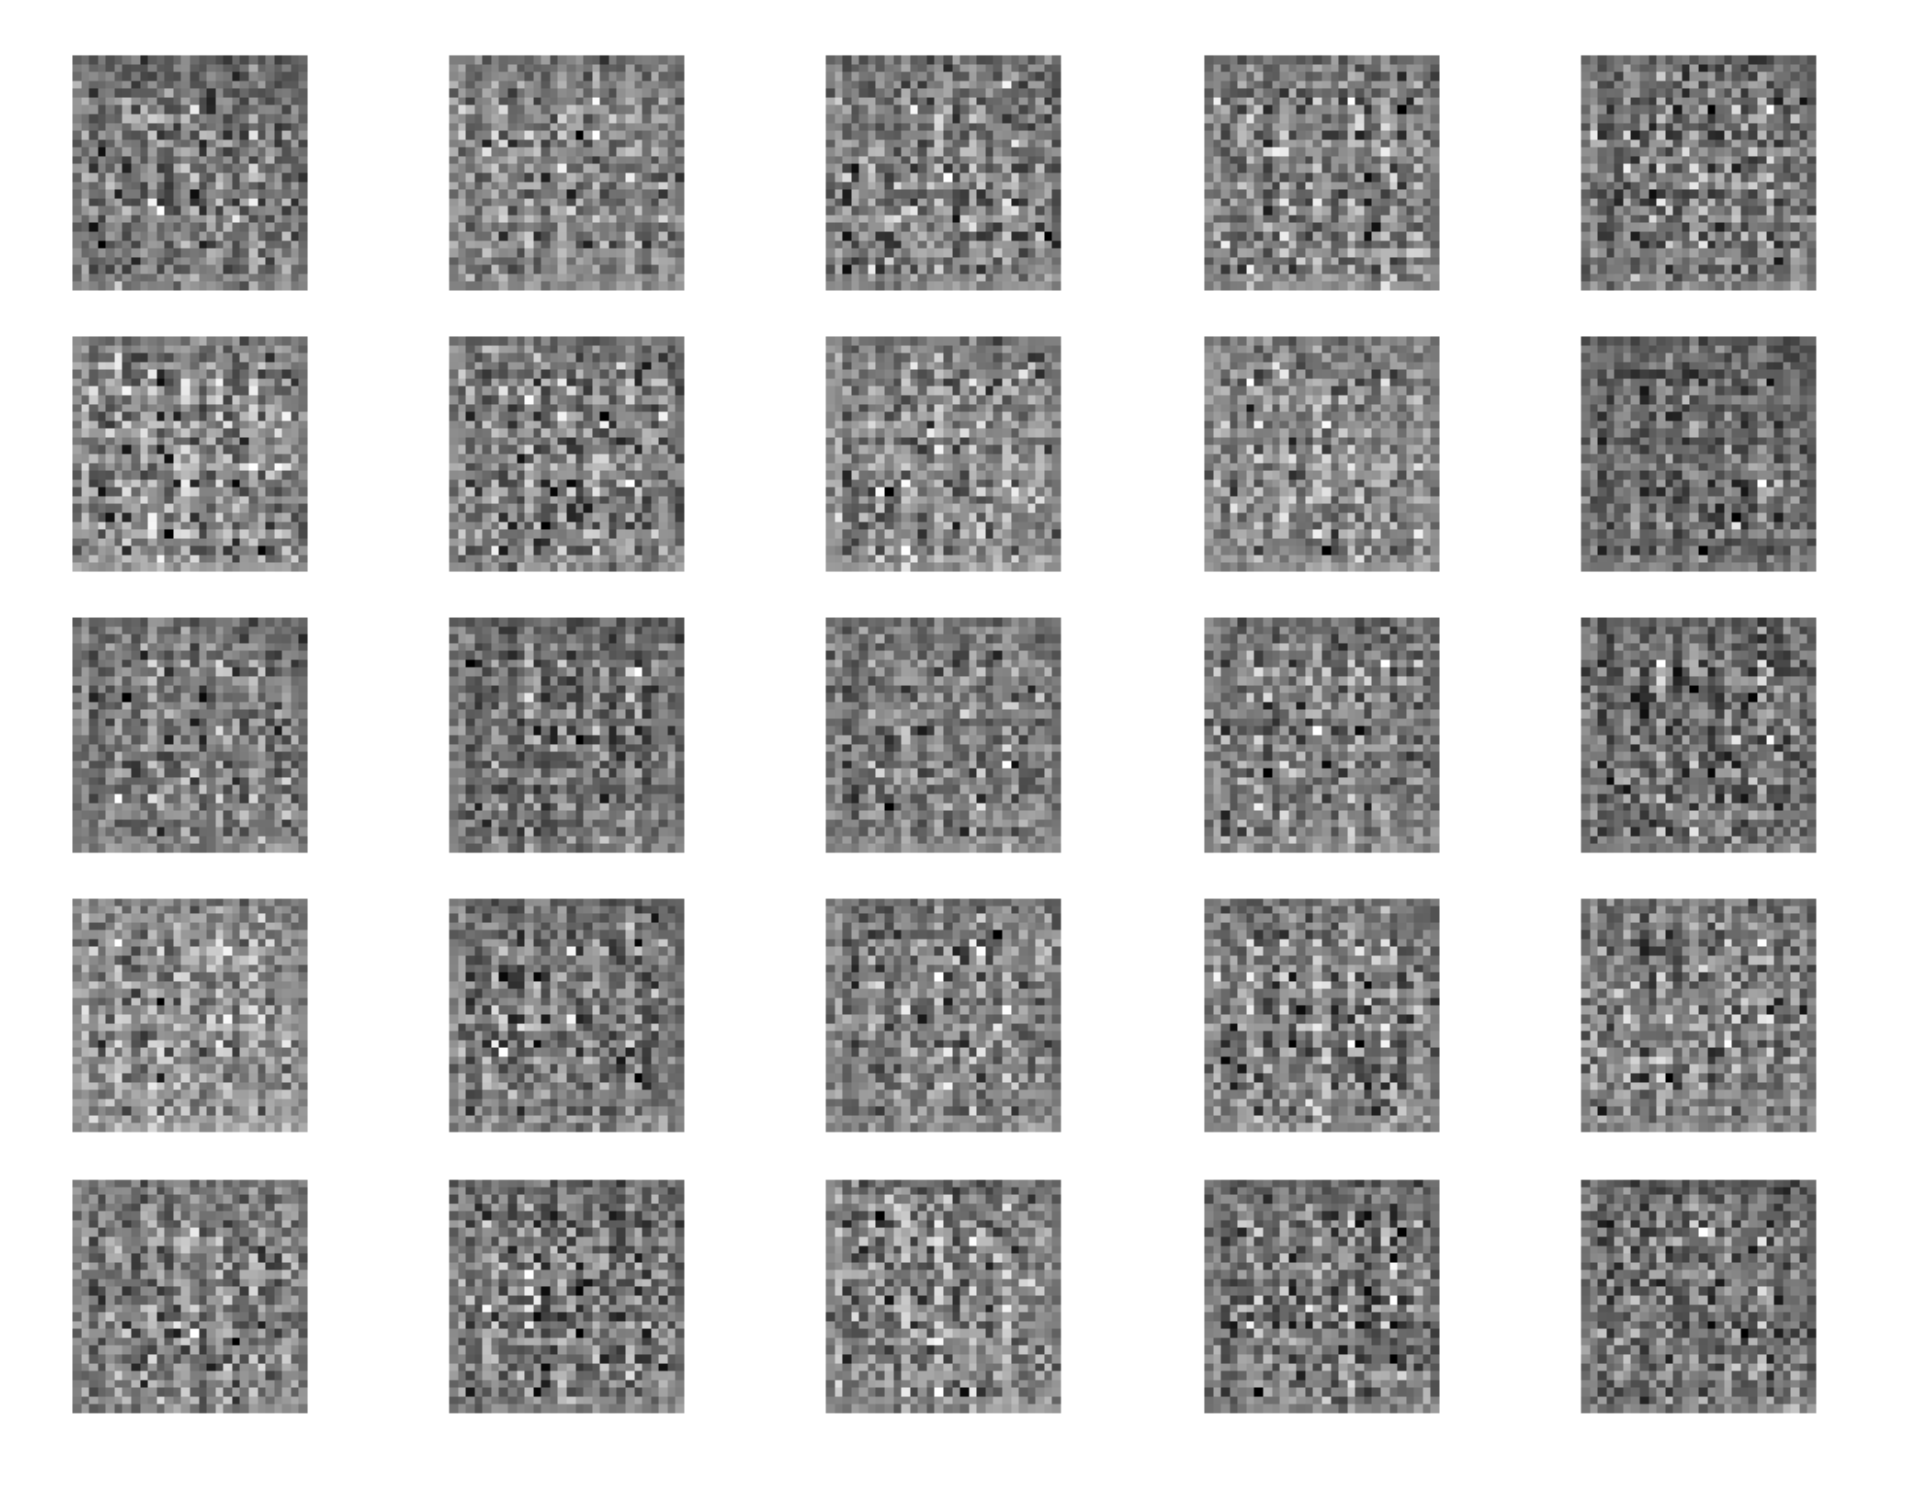

#### Приклад нашого зображення після нашої останньої епохи тренування:

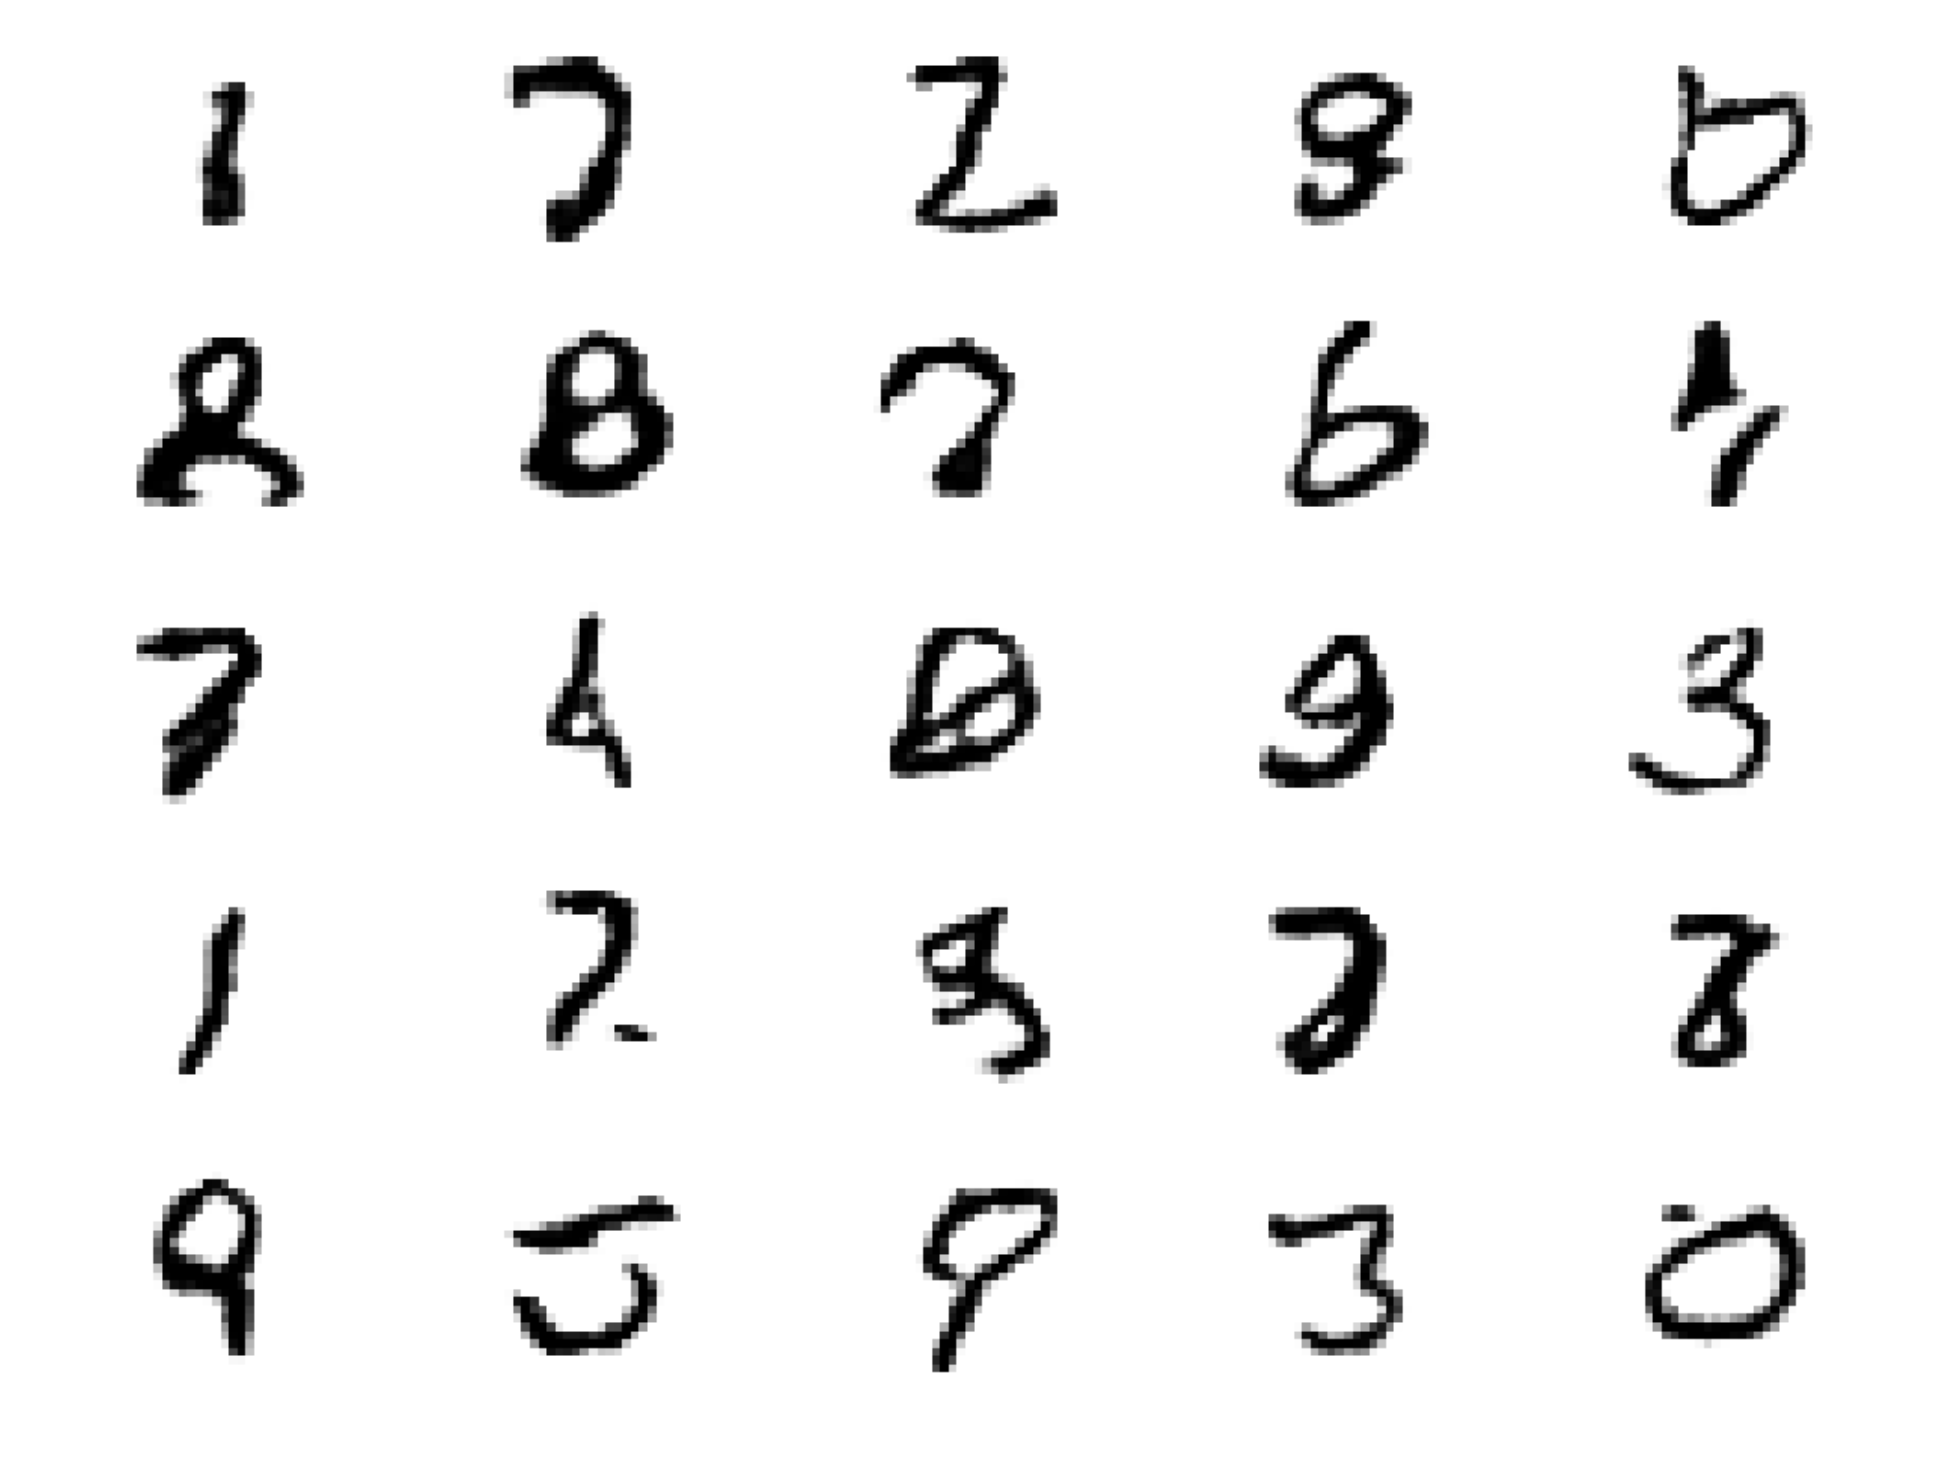

#### Приклад згенерованих чисел з оригінальної архітектури GAN на 200 епосі:

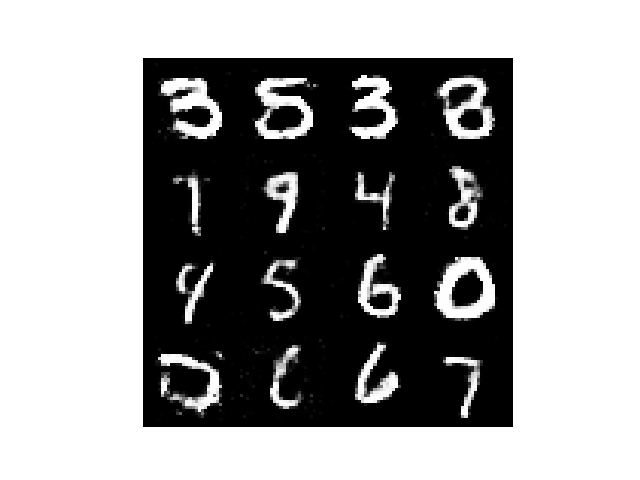

## Висновки
DCGAN (Deep Convolutional Generative Adversarial Network) - це специфічна архітектура генеративних змагальних мереж (GAN), призначена для задач генерації зображень. Вона вносить кілька модифікацій у звичайну архітектуру GAN, що може призвести до покращення стабільності та продуктивності. Ось кілька переваг, які DCGAN має над оригінальною архітектурою GAN:

1. **Стабільність у навчанні**
   - DCGAN розроблена таким чином, щоб бути більш стабільною під час тренувань у порівнянні з ванільними GAN. Вона включає в себе такі архітектурні особливості, як пакетна нормалізація, яка допомагає запобігти падінню режиму та покращити збіжність.

2. **Згорткові шари**
   - DCGAN використовує згорточні шари як у генераторі, так і в дискримінаторі, що є більш придатним для задач, пов'язаних із зображеннями. Згорткові шари допомагають ефективно фіксувати просторові ієрархії та закономірності.

3. **Згортки з дробовим кроком та згортки з дробовим кроком:**.
   - DCGAN використовує згортки з прямим кроком у дискримінаторі та згортки з дробовим кроком (транспоновані згортки) у генераторі. Це допомагає ефективно зменшувати та збільшувати просторові розміри, дозволяючи мережі вивчати ієрархічні ознаки.

4. **Відсутність повністю з'єднаних шарів**
   - DCGAN уникає використання повністю з'єднаних шарів у прихованих шарах, що зменшує ризик надмірної підгонки і допомагає охопити більше просторових ієрархій у даних.

5. **Пакетна нормалізація:**
   - Пакетна нормалізація застосовується як у генераторі, так і в дискримінаторі DCGAN. Це допомагає нормалізувати активації, зменшити внутрішній зсув коваріацій та покращити стабільність навчання.

6. **Негерметичні випрямлені лінійні блоки (Leaky ReLU):**.
   - DCGAN використовує функції активації Leaky ReLU замість традиційних ReLU. Leaky ReLU допомагає запобігти появі мертвих нейронів і забезпечує невеликий ненульовий градієнт, коли вхідний сигнал є негативним, що може бути корисним для процесу навчання.

7. **Нормалізація на виході генератора:**
   - DCGAN використовує тангенс активацію у вихідному шарі генератора, нормалізуючи вихід генератора до певного діапазону (зазвичай [-1, 1]). Це допомагає відповідати масштабу реальних даних і сприяє стабільності навчання.

8. **Згладжування міток**
   - DCGAN іноді використовує згладжування міток, коли замість присвоєння міток 0 і 1 для справжніх і фальшивих зразків, мітки замінюються випадковими значеннями в невеликому діапазоні. Це може запобігти надмірній самовпевненості дискримінатора.

Ці модифікації в сукупності сприяють підвищенню продуктивності та стабільності DCGAN у створенні реалістичних зображень порівняно з ванільною архітектурою GAN.

# END